In [3]:
# HIDE
import pandas as pd
import numpy as np
np.random.seed(7)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True, context="talk")
from IPython import display
%matplotlib inline

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import keras as ke
import keras.backend as K
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.models import load_model


create_gif = False

# model reconstruction from JSON:
from keras.models import model_from_json

print(f"sklearn: {sk.__version__}")
print(f"pandas: {pd.__version__}")
print(f"kerads: {ke.__version__}")


import src.my_functions_product1 as myFC
import matplotlib.pyplot as plt

Using TensorFlow backend.


sklearn: 0.19.1
pandas: 0.23.0
kerads: 2.1.6


In [4]:
input_option = 'not manual'
#-----------------------------------------------
feature_path = 'Feature-Datasets/adult/'
data_filename = 'adult.data'

train_or_untrained = 'trained'
user_main_json_text_file = 'user1_main_task_arch_json_string_file.txt'
user_adv_json_text_file = 'user1_adv_task_arch_json_string_file.txt'
h5_filename = 'user1_main_task_ori_trained_model.h5'



#feature_path = 'Feature-Datasets/bank/'
#data_filename = 'bank.csv'

## Input your architecture and trained model

In [6]:
user_main_json_text_file,user_adv_json_text_file,h5_filename,result_fname,train_or_untrain = myFC.user_model_arch_feature_input(input_option,
                                                                                                                                feature_path,data_filename,user_main_json_text_file,user_adv_json_text_file,train_or_untrained,h5_filename)

In [7]:
#user1_main_task_arch_json_string_file.txt
#user1_adv_task_arch_json_string_file.txt
#user1_main_task_ori_trained_model.h5

## Reading the json files for main task and adversary

In [8]:
main_task_arch_json_string = myFC.read_txt_file_to_string(user_main_json_text_file)
adv_task_arch_json_string = myFC.read_txt_file_to_string(user_adv_json_text_file)

## Feature Reading

In [9]:
X_train, Z_train, y_train = myFC.feature_file_reading(feature_path,'train')
X_test, Z_test, y_test = myFC.feature_file_reading(feature_path,'test')

## Model and compile only main task: check prediction results

In [10]:
save_the_weights = (train_or_untrain == 'untrained')
main_task_accuracy, p_rule_for_Y1, y_pred = myFC.pre_train_main_task(main_task_arch_json_string,X_train, y_train,X_test,y_test,Z_test,save_the_weights=save_the_weights,h5_file_name=h5_filename)

Accuracy: 85.41


## Combining the main task arch with the adversarial arch

### Train using pre-trained weights of main model

In [11]:
tradeoff_lambda_v = [12] 
pre_load_flag = True

main_task_trained_weight_file = h5_filename#'main_task_ori_trained_model.h5'

for tradeoff_lambda in tradeoff_lambda_v:
    print('tradeoff_lambda = ', tradeoff_lambda)

    Bacc, Bp,B_y_pred, Aacc, Ap,A_y_pred,tradeoff_lambda = myFC.run_it_for_one_lambda(tradeoff_lambda,main_task_arch_json_string,adv_task_arch_json_string,pre_load_flag,main_task_trained_weight_file,X_train, y_train,Z_train,X_test,y_test,Z_test)
    result_fname_y_pred_before_after,result_fname_acc_p_before_after = myFC.saving_performance_result(Bacc, Bp,B_y_pred, Aacc, Ap,A_y_pred,tradeoff_lambda,result_fname)






tradeoff_lambda =  12
Accuracy: 85.39
Accuracy: 83.02


## Reading the result files

### Accuracy & p-score trade-off curves

In [13]:
tradeoff_lambda_v = [12]  
Bacc_Bp_Aacc_Ap_results = np.zeros([len(tradeoff_lambda_v),4])

for item in range(len(tradeoff_lambda_v)):
    
    tradeoff_lambda = tradeoff_lambda_v[item]
    result_fname_acc_p_before_after = result_fname +'Result_acc_p_BA_' + 'L'+ str(tradeoff_lambda)+'.txt'
    Bacc_Bp_Aacc_Ap = np.loadtxt(result_fname_acc_p_before_after, delimiter=',')
    Bacc_Bp_Aacc_Ap_results[item, :] = Bacc_Bp_Aacc_Ap

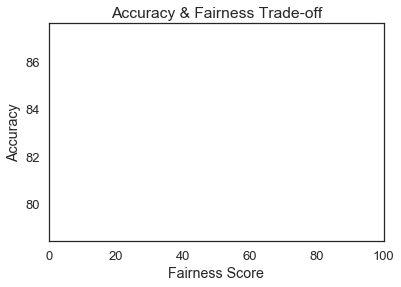

In [14]:
path = 'Data/adult/'
which_model = 'user_model'

demo = 'two_'
fname = path+'Figure-results/'+demo+which_model+'_'+'Trade'
plt.plot(Bacc_Bp_Aacc_Ap_results[:,3], 100*Bacc_Bp_Aacc_Ap_results[:,2])
plt.xlabel('Fairness Score')
plt.ylabel('Accuracy')
plt.title('Accuracy & Fairness Trade-off')
plt.xlim(0,100)
#plt.ylim(0,100)
plt.savefig(fname, bbox_inches='tight')




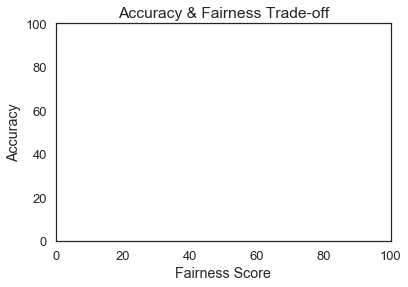

In [15]:
fname = path+'Figure-results/'+demo+which_model+'_'+'Trade-off-zoomout'
plt.plot(Bacc_Bp_Aacc_Ap_results[:,3], 100*Bacc_Bp_Aacc_Ap_results[:,2])
plt.xlabel('Fairness Score')
plt.ylabel('Accuracy')
plt.title('Accuracy & Fairness Trade-off')
plt.xlim(0,100)
plt.ylim(0,100)
plt.savefig(fname, bbox_inches='tight')

#### Before & After Results

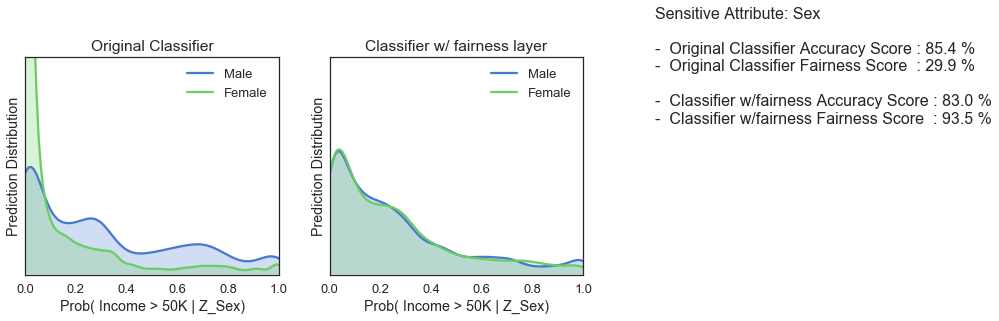

In [16]:

sensitive_class0 = 'Male'
sensitive_class1 = 'Female'
sensitive_field = 'Sex'
good_outcome = 'Income > 50K'

target_label0 = '<=50K'
target_label1 = '>50K'



which_result = 0


fname = path+'Figure-results/'+demo+which_model+'_'+sensitive_field+good_outcome+'.png'

tradeoff_lambda = tradeoff_lambda_v[which_result]
result_fname_y_pred_before_after = result_fname + 'Result_y_pred_'+'L' + str(tradeoff_lambda) +'.txt'
BA_y_pred = np.loadtxt(result_fname_y_pred_before_after, delimiter=',')

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)


# without adversarial training
ax = sns.distplot(BA_y_pred[Z_test == 0,0], hist=False, 
                  kde_kws={'shade': True,},
                  label='{}'.format(sensitive_class0),ax=axes[0])

ax = sns.distplot(BA_y_pred[Z_test == 1,0], hist=False, 
                  kde_kws={'shade': True,},
                  label='{}'.format(sensitive_class1),ax=axes[0])
ax.set_xlim(0,1)
ax.set_ylim(0,5)
ax.set_yticks([])
ax.set_title("Original Classifier")#.format(sensitive_field))
ax.set_ylabel('Prediction Distribution')
ax.set_xlabel('Prob( {} | Z_{})'.format(good_outcome,sensitive_field))

# with adversarial training
ax = sns.distplot(BA_y_pred[Z_test == 0,1], hist=False, 
                  kde_kws={'shade': True,},
                  label='{}'.format(sensitive_class0),ax=axes[1])

ax = sns.distplot(BA_y_pred[Z_test == 1,1], hist=False, 
                  kde_kws={'shade': True,},
                  label='{}'.format(sensitive_class1),ax=axes[1])
ax.set_xlim(0,1)
ax.set_ylim(0,5)
ax.set_yticks([])
ax.set_title("Classifier w/ fairness layer")#.format(sensitive_field))
ax.set_ylabel('Prediction Distribution')
ax.set_xlabel('Prob( {} | Z_{})'.format(good_outcome,sensitive_field))


fig.text(1.0, 0.65, ''.join([f"Sensitive Attribute: {sensitive_field}\n\n",
                                       f"-  Original Classifier Accuracy Score : {100*Bacc_Bp_Aacc_Ap_results[which_result,0]:.1f} %\n",
                                       f"-  Original Classifier Fairness Score  : {Bacc_Bp_Aacc_Ap_results[which_result,1]:.1f} %\n\n",
                                       f"-  Classifier w/fairness Accuracy Score : {100*Bacc_Bp_Aacc_Ap_results[which_result,2]:.1f} %\n",
                                       f"-  Classifier w/fairness Fairness Score  : {Bacc_Bp_Aacc_Ap_results[which_result,3]:.1f} %"]),
                 fontsize='16')

plt.savefig(fname, bbox_inches='tight')

## FNR FPR

In [18]:
#result_fname = path + 'Trade-off-results/'+'FNR_FPR.txt'

Z_test = np.array(Z_test)
y_test = np.array(y_test)

#let's focus on sensitive class 0
samples = Z_test==0
y_test_samples = np.array(y_test[samples])
y_pred = np.array(BA_y_pred[:,0])
y_pred_samples = y_pred[samples]
FNR, FPR = myFC.FNR_FPR(y_pred_samples,y_test_samples)
print('Sensitive Class 0 w/o fairness FNR= {}, FPR= {}\n'.format(FNR,FPR))

#let's focus on sensitive class 0
samples = Z_test==0
y_test_samples = np.array(y_test[samples])
y_pred = np.array(BA_y_pred[:,1])
y_pred_samples = y_pred[samples]
FNR, FPR = myFC.FNR_FPR(y_pred_samples,y_test_samples)
print('Sensitive Class 0 w/ fairness FNR= {}, FPR= {}\n'.format(FNR,FPR))

print('-'*80+'\n')
#let's focus on sensitive class 1
samples = Z_test==1
y_test_samples = np.array(y_test[samples])
y_pred = np.array(BA_y_pred[:,0])
y_pred_samples = y_pred[samples]
FNR, FPR = myFC.FNR_FPR(y_pred_samples,y_test_samples)
print('Sensitive Class 1 w/o fairness FNR= {}, FPR= {}\n'.format(FNR,FPR))

#let's focus on sensitive class 1
samples = Z_test==1
y_test_samples = np.array(y_test[samples])
y_pred = np.array(BA_y_pred[:,1])
y_pred_samples = y_pred[samples]
FNR, FPR = myFC.FNR_FPR(y_pred_samples,y_test_samples)
print('Sensitive Class 1 w/ fairness FNR= {}, FPR= {}\n'.format(FNR,FPR))




Sensitive Class 0 w/o fairness FNR= 0.3464210208396255, FPR= 0.11133174477098226

Sensitive Class 0 w/ fairness FNR= 0.560555723346421, FPR= 0.04805401111993646

--------------------------------------------------------------------------------

Sensitive Class 1 w/o fairness FNR= 0.4540983606557377, FPR= 0.02372528616024974

Sensitive Class 1 w/ fairness FNR= 0.25245901639344265, FPR= 0.0813735691987513



## Let's plot how individuals move around 
### subsample the samples



In [19]:
#subsample the samples
samples = np.random.randint(y_pred.shape[0], size=1000)

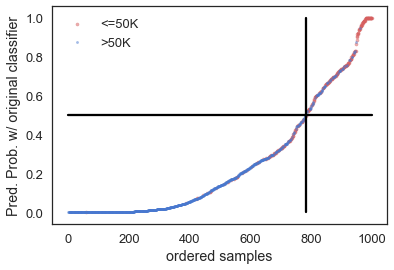

In [23]:
#predictions from the original classifier
y_pred = np.array(BA_y_pred[:,0])
sy_pred = y_pred[samples]
sy_test = y_test[samples]
sZ_test = Z_test[samples]

#samples ordered according to their prediction values
order_y_pred = sy_pred.argsort()

#Let's order other vectors as well.
Z_test_o = sZ_test[order_y_pred]
y_test_o = sy_test[order_y_pred]
y_pred_o = sy_pred[order_y_pred]
vec = np.arange(sy_pred.shape[0])

ones = y_pred_o>0.5
border_one = np.where(y_pred_o>0.5)
border_one = border_one[0][0]



tar0_rows = (y_test_o == 0)
tar1_rows = (y_test_o == 1)

plt.figure(1)
plt.scatter(vec[tar1_rows], y_pred_o[tar1_rows], s=10,c="r", alpha=0.5,marker='o',label=target_label0)
plt.scatter(vec[tar0_rows], y_pred_o[tar0_rows], s=5,c="b", alpha=0.5,label=target_label1)
plt.plot(vec,0.5*np.ones_like(vec),c='black')
plt.plot(border_one*np.ones_like(np.array([0,1])),np.array([0,1]),c='black')
plt.xlabel("ordered samples")
plt.ylabel("Pred. Prob. w/ original classifier")
plt.legend(loc=2)
#plt.title('Predictions with original classifier')
fname = path+'Figure-results/'+demo+which_model+'_'+sensitive_field+good_outcome+'points1_'+'.png'
plt.savefig(fname, bbox_inches='tight')

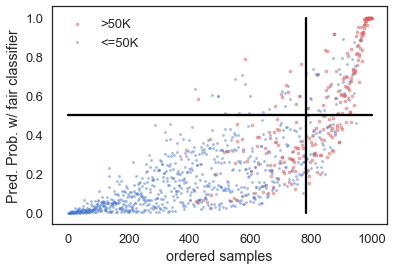

In [24]:
#predictions from the original classifier
y_pred = np.array(BA_y_pred[:,1])
sy_pred = y_pred[samples]
sy_test = y_test[samples]
sZ_test = Z_test[samples]

#samples ordered according to their prediction values
#order_y_pred = sy_pred.argsort()

#Let's order other vectors as well.
Z_test_o = sZ_test[order_y_pred]
y_test_o = sy_test[order_y_pred]
y_pred_o = sy_pred[order_y_pred]
vec = np.arange(sy_pred.shape[0])


tar0_rows = (y_test_o == 0)
tar1_rows = (y_test_o == 1)

plt.figure(1)
plt.scatter(vec[tar1_rows], y_pred_o[tar1_rows], s=10,c="r", alpha=0.5,marker='o',label=target_label1)
plt.scatter(vec[tar0_rows], y_pred_o[tar0_rows], s=5,c="b", alpha=0.5,label=target_label0)
plt.plot(vec,0.5*np.ones_like(vec),c='black')
plt.plot(border_one*np.ones_like(np.array([0,1])),np.array([0,1]),c='black')
plt.xlabel("ordered samples")
plt.ylabel("Pred. Prob. w/ fair classifier")
plt.legend(loc=2)
#plt.title('Predictions with fair classifier')
fname = path+'Figure-results/'+demo+which_model+'_'+sensitive_field+good_outcome+'points2_'+'.png'
plt.savefig(fname, bbox_inches='tight')

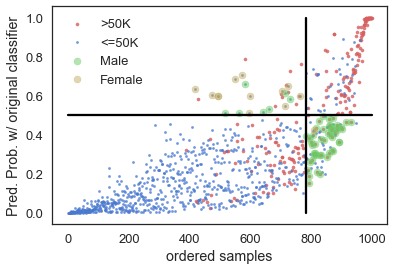

In [25]:
#predictions from the original classifier
y_pred = np.array(BA_y_pred[:,1])
sy_pred = y_pred[samples]
sy_test = y_test[samples]
sZ_test = Z_test[samples]

#samples ordered according to their prediction values
#order_y_pred = sy_pred.argsort()

#Let's order other vectors as well.
Z_test_o = sZ_test[order_y_pred]
y_test_o = sy_test[order_y_pred]
y_pred_o = sy_pred[order_y_pred]
vec = np.arange(sy_pred.shape[0])


tar0_rows = (y_test_o == 0)
tar1_rows = (y_test_o == 1)

#lower boundary
tar0_y_pred1_rows_Z0 = (y_test_o[:border_one] == 0)&(y_pred_o[:border_one] > 0.5)& (Z_test_o[:border_one]==0)
tar0_y_pred1_rows_Z1 = (y_test_o[:border_one] == 0)&(y_pred_o[:border_one] > 0.5)& (Z_test_o[:border_one]==1)

#upper boundary
tar1_y_pred0_rows_Z0u = (y_test_o[border_one:] == 1)&(y_pred_o[border_one:] < 0.5)& (Z_test_o[border_one:]==0)
tar1_y_pred0_rows_Z1u = (y_test_o[border_one:] == 1)&(y_pred_o[border_one:] < 0.5)& (Z_test_o[border_one:]==1)

plt.figure(1)
plt.scatter(vec[tar1_rows], y_pred_o[tar1_rows], s=10,c="r", alpha=0.8,marker='o',label=target_label1)
plt.scatter(vec[tar0_rows], y_pred_o[tar0_rows], s=5,c="b", alpha=0.8,label=target_label0)

plt.scatter(vec[:border_one][tar0_y_pred1_rows_Z0], y_pred_o[:border_one][tar0_y_pred1_rows_Z0], s=50,c="g", alpha=0.5,marker='o',label=sensitive_class0)
plt.scatter(vec[:border_one][tar0_y_pred1_rows_Z1], y_pred_o[:border_one][tar0_y_pred1_rows_Z1], s=50,c="y", alpha=0.5,marker='o',label=sensitive_class1)

plt.scatter(vec[border_one:][tar1_y_pred0_rows_Z0u], y_pred_o[border_one:][tar1_y_pred0_rows_Z0u], s=50,c="g", alpha=0.5,marker='o')
plt.scatter(vec[border_one:][tar1_y_pred0_rows_Z1u], y_pred_o[border_one:][tar1_y_pred0_rows_Z1u], s=50,c="y", alpha=0.5,marker='o')



plt.plot(vec,0.5*np.ones_like(vec),c='black')
plt.plot(border_one*np.ones_like(np.array([0,1])),np.array([0,1]),c='black')
plt.xlabel("ordered samples")
plt.ylabel("Pred. Prob. w/ original classifier")
plt.legend(loc=2)
#plt.title('Predictions with fair classifier')
fname = path+'Figure-results/'+demo+which_model+'_'+sensitive_field+good_outcome+'points3_'+'.png'
plt.savefig(fname, bbox_inches='tight')

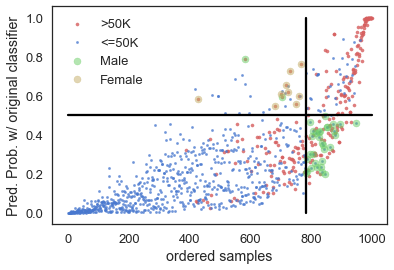

In [26]:
#predictions from the original classifier
y_pred = np.array(BA_y_pred[:,1])
sy_pred = y_pred[samples]
sy_test = y_test[samples]
sZ_test = Z_test[samples]

#samples ordered according to their prediction values
#order_y_pred = sy_pred.argsort()

#Let's order other vectors as well.
Z_test_o = sZ_test[order_y_pred]
y_test_o = sy_test[order_y_pred]
y_pred_o = sy_pred[order_y_pred]
vec = np.arange(sy_pred.shape[0])


tar0_rows = (y_test_o == 0)
tar1_rows = (y_test_o == 1)

#upper boundary
tar0_y_pred0_rows_Z0u = (y_test_o[border_one:] == 0)&(y_pred_o[border_one:] <= 0.5)& (Z_test_o[border_one:]==0)
tar0_y_pred0_rows_Z1u = (y_test_o[border_one:] == 0)&(y_pred_o[border_one:] <= 0.5)& (Z_test_o[border_one:]==1)

#lower boundary
tar1_y_pred1_rows_Z0 = (y_test_o[:border_one] == 1)&(y_pred_o[:border_one] > 0.5)& (Z_test_o[:border_one]==0)
tar1_y_pred1_rows_Z1 = (y_test_o[:border_one] == 1)&(y_pred_o[:border_one] > 0.5)& (Z_test_o[:border_one]==1)

plt.figure(1)
plt.scatter(vec[tar1_rows], y_pred_o[tar1_rows], s=10,c="r", alpha=0.8,marker='o',label=target_label1)
plt.scatter(vec[tar0_rows], y_pred_o[tar0_rows], s=5,c="b", alpha=0.8,label=target_label0)

plt.scatter(vec[border_one:][tar0_y_pred0_rows_Z0u], y_pred_o[border_one:][tar0_y_pred0_rows_Z0u], s=50,c="g", alpha=0.5,marker='o',label=sensitive_class0)
plt.scatter(vec[border_one:][tar0_y_pred0_rows_Z1u], y_pred_o[border_one:][tar0_y_pred0_rows_Z1u], s=50,c="y", alpha=0.5,marker='o',label=sensitive_class1)

plt.scatter(vec[:border_one][tar1_y_pred1_rows_Z0], y_pred_o[:border_one][tar1_y_pred1_rows_Z0], s=50,c="g", alpha=0.5,marker='o')
plt.scatter(vec[:border_one][tar1_y_pred1_rows_Z1], y_pred_o[:border_one][tar1_y_pred1_rows_Z1], s=50,c="y", alpha=0.5,marker='o')



plt.plot(vec,0.5*np.ones_like(vec),c='black')
plt.plot(border_one*np.ones_like(np.array([0,1])),np.array([0,1]),c='black')
plt.xlabel("ordered samples")
plt.ylabel("Pred. Prob. w/ original classifier")
plt.legend(loc=2)
#plt.title('Predictions with fair classifier')
fname = path+'Figure-results/'+demo+which_model+'_'+sensitive_field+good_outcome+'points4_'+'.png'
plt.savefig(fname, bbox_inches='tight')